In [1]:
#from IPython.core.display import clear_output

#!pip3 install pandas-profiling==2.11
#clear_output()

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#! cp /content/drive/MyDrive/semester7/Thesis/Models/* ./ -r
#! cp /content/drive/MyDrive/semester7/Thesis/Datasets/* ./ -r

In [3]:
#!gdown 1YHqgEFHoXa5vpSfKteAhBUWsJJ2RHgS7 -O data.csv

In [4]:
cd ..

/home/danil-pass123/Desctop/semester7/Thesis/Model_stage5_after_session _stage2


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn.datasets import make_regression
#from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale

from Datasets.ProcessDataset import Dataset

#import torch
from sklearn.model_selection import train_test_split

#from Models.LogisticRegression.LogisticRegression import Logistic_Regression
#from Models.LogisticRegression.LogisticRegression_layer import Logistic_Regression_train
from Models.LogisticRegression.LogisticRegression_numpy import Logistic_Regression_numpy
from Models.LogisticRegression.LogisticRegression_sklearn import Logistic_Regression_origin

from Models.FederatedLearning.Server import server
from Models.FederatedLearning.Worker import worker

from Models.MatrixScheduler.MatrixScheduler_identical import MatrixScheduler_identical
from Models.MatrixScheduler.MatrixScheduler_Uniform import MatrixScheduler_Uniform
#from Models.MatrixScheduler.MatrixScheduler_k import MatrixScheduler_k
#from Models.MatrixScheduler.MatrixScheduler_k_array import MatrixScheduler_k_array

from Models.StatisticClass import Statistic
from Models.StatisticClass import comparsion_array_loss,comparsion_array_weights,comparsion_array_acc

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression


#from sklearn.metrics import balanced_accuracy_score
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import confusion_matrix

%matplotlib inline

In [6]:
from Models.StatisticClass import k_scheduler_statistic_draw1
from Models.StatisticClass import comparsion_array_loss
from Models.StatisticClass import comparsion_array_weights
from Models.StatisticClass import comparsion_array_acc

In [7]:
import random
random.seed(42)

# load Dataset

In [8]:
data = Dataset(dataset_name = 'Titanic')
X,y = data.X,data.y

In [9]:
cd Reports

/home/danil-pass123/Desctop/semester7/Thesis/Model_stage5_after_session _stage2/Reports


# Classification Model

In [10]:
#X = d_class
#y = y_class
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#X_train,y_train,X_test,y_test = torch.tensor(X_train),torch.tensor(y_train),torch.tensor(X_test),torch.tensor(y_test)

In [11]:
LR_EPOCH = {'lr': 0.01, 'epoch': 1000}

In [12]:
stat_origin = Statistic(X_test,y_test,"sklearn model")
log_regr = Logistic_Regression_origin(stat_collector=stat_origin,lr = LR_EPOCH['lr'],epoch = LR_EPOCH['epoch'])

log_regr.train(X_train,y_train)

In [13]:
stat_np = Statistic(X_test,y_test,"numpy model")
log_regr_n = Logistic_Regression_numpy(n_features = X_train.shape[1],lr = LR_EPOCH['lr'],
                                       epoch = LR_EPOCH['epoch'],stat_collector=stat_np)
log_regr_n.train(X_train,y_train)

# Federated learning

In [14]:
#M_NAMES = ["Logistic_Regression_train", "Logistic_Regression","Logistic_Regression_numpy"]
M_NAMES = "Logistic_Regression_numpy"

In [15]:
model_name = M_NAMES#[2]
model_params = {"lr":LR_EPOCH['lr']}
model_name, model_params

('Logistic_Regression_numpy', {'lr': 0.01})

## Example 1 Global update on each iterations

### с единичной матрицей (Scheduler)

In [16]:
schedulers = [MatrixScheduler_identical()]
federated_sch_stat_collectors = [Statistic(X_test,y_test,"worker1_scheduler")]

s = server(f_model_name = model_name,model_params = model_params,
           stat_collectors = federated_sch_stat_collectors, M_workers=1,
           X_train = X_train,y_train = y_train,
           data_splitter = 'id',m_scheduler = schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=1)

Loss, Weigths, Accuracy Plots

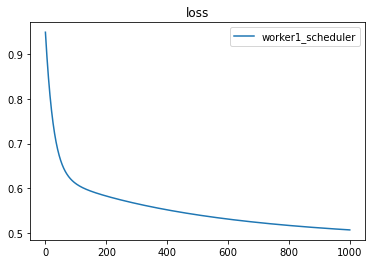

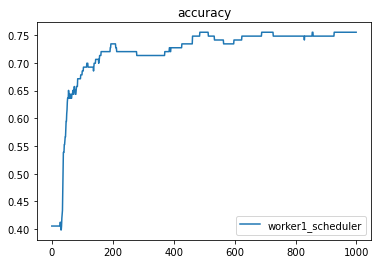

balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552


In [17]:
federated_sch_stat_collectors[0].loss_plot()
federated_sch_stat_collectors[0].acc_plot()

federated_sch_stat_collectors[0].c_matrix
federated_sch_stat_collectors[0].print_accuracy()

#### сравнение с numpy

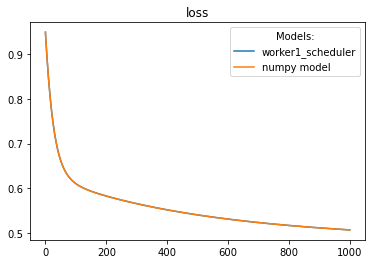

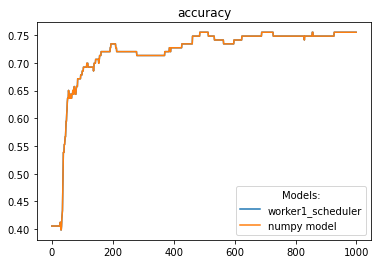

difference(worker1_scheduler,numpy model) = worker1_scheduler - numpy model


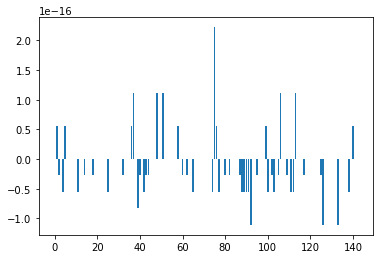

MSE(worker1_scheduler,numpy model) = 3.422901451117803e-18


In [18]:
#stat_np,stat_origin
federated_sch_stat_collectors[0].comparison_loss_plot(stat_np)
federated_sch_stat_collectors[0].comparison_accuracy_plot(stat_np)
federated_sch_stat_collectors[0].comparison_mse(stat_np)

### с матрицей из Равномерного расспределения (Scheduler)

In [34]:
scheduler1 = [MatrixScheduler_Uniform(alpha=0.01,gamma=3,change_mode = MatrixScheduler_Uniform.change_on_each_iteration)]
federated_sch_u_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_s")]

s = server(f_model_name = model_name,model_params = model_params,
           stat_collectors = federated_sch_u_stat_collectors, M_workers=1,
           X_train = X_train,y_train = y_train,
           data_splitter = 'id',m_scheduler = scheduler1)

s.run(n_iter=LR_EPOCH['epoch'],T=1)

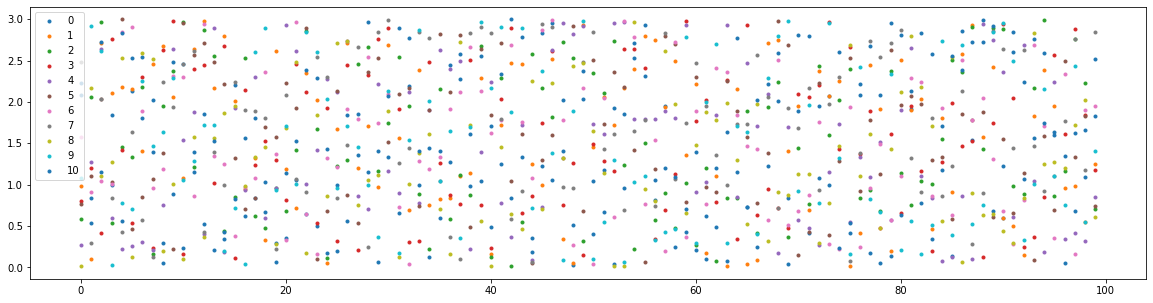

In [35]:
plt.figure(figsize=(20, 5))
for j in range(11):
    array = []
    for i in range(100):#len(scheduler1[0].diagonal_values_history)):
        array.append(scheduler1[0].diagonal_values_history[i][j])
    plt.plot(np.arange(100),array,'.',label = j)
plt.legend()
plt.show()


Loss, Weigths, Accuracy Plots

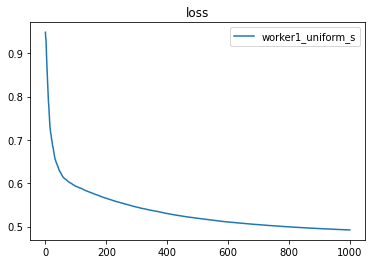

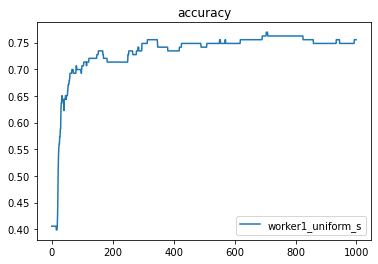

balanced_accuracy_score: 0.7366125760649087
accuracy_score: 0.7552447552447552
Train:
Min val: 0.0,Max val: 0.8891648678757897,Mean: 0.4007134042977995            ,Var: 0.053933387781917426
Test:
Min val: 0.14092192161605716,Max val: 0.8891648678757897,Mean: 0.4007134042977995            ,Var: 0.053933387781917426


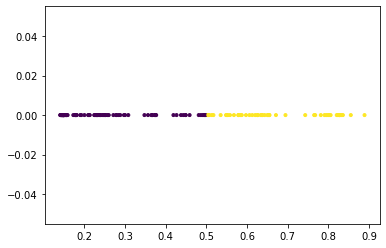

In [36]:
federated_sch_u_stat_collectors[0].loss_plot()
federated_sch_u_stat_collectors[0].acc_plot()

#current_stat_collector.plot_confusion_matrix()
federated_sch_u_stat_collectors[0].print_accuracy()

federated_sch_u_stat_collectors[0].show_y_distr()

#### сравнение с примером c единичной матрицы (scheduler)

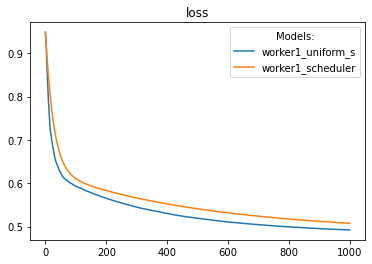

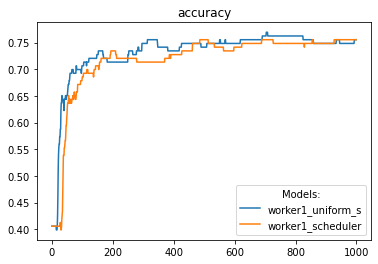

worker1_uniform_s


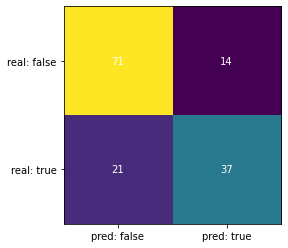

[[71 14]
 [21 37]]
balanced_accuracy_score: 0.7366125760649087
accuracy_score: 0.7552447552447552
worker1_scheduler


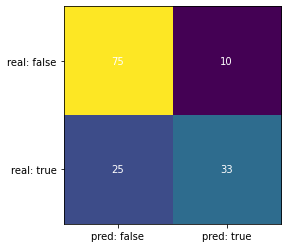

[[75 10]
 [25 33]]
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
difference(worker1_uniform_s,worker1_scheduler) = worker1_uniform_s - worker1_scheduler


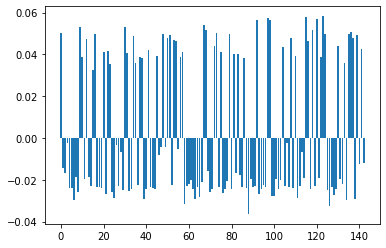

MSE(worker1_uniform_s,worker1_scheduler) = 0.0028055310908928614


In [37]:
#stat_np,stat_origin
current_stat_collector1 = federated_sch_u_stat_collectors[0]
current_stat_collector2 = federated_sch_stat_collectors[0]

current_stat_collector1.comparison_loss_plot(current_stat_collector2)
current_stat_collector1.comparison_accuracy_plot(current_stat_collector2)

print(current_stat_collector1.lable)

current_stat_collector1.plot_confusion_matrix()
current_stat_collector1.print_accuracy()

print(current_stat_collector2.lable)
current_stat_collector2.plot_confusion_matrix()
current_stat_collector2.print_accuracy()

current_stat_collector1.comparison_mse(current_stat_collector2)

In [38]:
#federated_sch_u_stat_collectors[0].der_mean_plot()

#plt.plot(federated_sch_u_stat_collectors[0].iter_list,federated_sch_u_stat_collectors[0].estimated_der,label="est")
#plt.plot(federated_sch_u_stat_collectors[0].iter_list,federated_sch_u_stat_collectors[0].derivative_mean,label="der")
#plt.legend()
#plt.show()

#federated_sch_u_stat_collectors[0].comparison_der_mean_plot(federated_sch_stat_collectors[0])

In [39]:
#for i in range(11):
#    federated_sch_u_stat_collectors[0].comparison_der_plot(federated_sch_stat_collectors[0],i)

In [40]:
#for i in range(11):
#    federated_sch_u_stat_collectors[0].comparison_weight_plot(federated_sch_stat_collectors[0],i)

In [41]:
print(federated_sch_u_stat_collectors[0].lable)
print(federated_sch_u_stat_collectors[0].c_matrix)
federated_sch_u_stat_collectors[0].print_accuracy()
print(federated_sch_stat_collectors[0].lable)
print(federated_sch_stat_collectors[0].c_matrix)
federated_sch_stat_collectors[0].print_accuracy()

worker1_uniform_s
[[71 14]
 [21 37]]
balanced_accuracy_score: 0.7366125760649087
accuracy_score: 0.7552447552447552
worker1_scheduler
[[75 10]
 [25 33]]
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552


#### сравнение с numpy

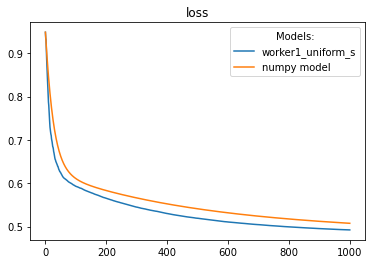

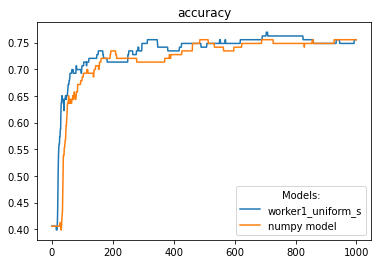

difference(worker1_uniform_s,numpy model) = worker1_uniform_s - numpy model


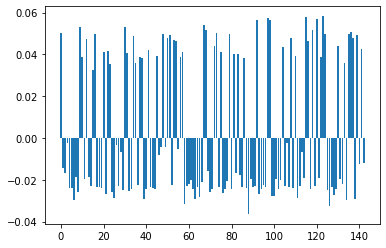

MSE(worker1_uniform_s,numpy model) = 0.0028055310908928622


In [42]:
#stat_np,stat_origin
federated_sch_u_stat_collectors[0].comparison_loss_plot(stat_np)
#federated_sch_u_stat_collectors[0].comparison_weights_plot(stat_np)
federated_sch_u_stat_collectors[0].comparison_accuracy_plot(stat_np)

federated_sch_u_stat_collectors[0].comparison_mse(stat_np)

In [28]:
#for i in range(11):
#    federated_stat_collectors[0].comparison_weight_plot(stat_np,i)#stat_origin

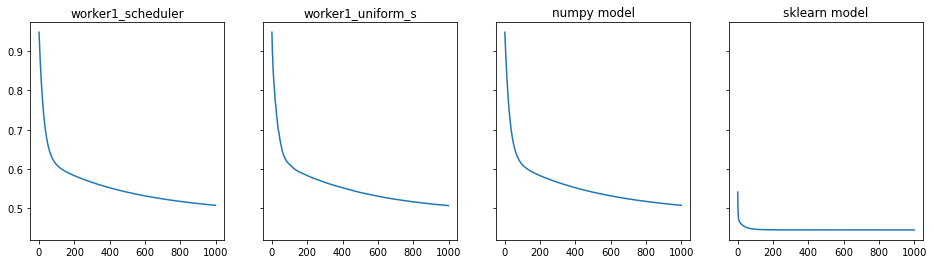

In [29]:
comparsion_array_loss([federated_sch_stat_collectors[0],federated_sch_u_stat_collectors[0],stat_np,stat_origin])
#comparsion_array_accuracy([federated_sch_stat_collectors[0],federated_stat_collectors[0],stat_np,stat_origin])